In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

In [173]:
data = pd.read_csv('Data/check_train.csv')
data_test = pd.read_csv('Data/check_test.csv')

In [174]:
data.columns

Index(['TOWN', 'FLAT_TYPE', 'FLOOR_AREA_SQM', 'FLAT_MODEL',
       'LEASE_COMMENCE_DATA', 'RESALE_PRICE', 'YEAR', 'FLOOR_MIN', 'FLOOR_MAX',
       'FLAT_AGE', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'MAX_FLOOR',
       'PLANNING_AREA', 'MIN_MRT_DIST', 'MRT_STATUS', 'MIN_MRT(OPEN)_DIST',
       'MIN_HAWK_DIST', 'HAWK_TYPE', 'HAWK_OWNER', 'HAWK_NUMBER_OF_STALLS',
       'MIN_PS_DIST', 'MIN_SS_DIST', 'MIN_MALL_DIST', 'cbd_dist',
       'NUM_MRT_WITHIN_1.5KM', 'NUM_HAWK_WITHIN_1.5KM', 'NUM_PS_WITHIN_1.5KM',
       'NUM_SS_WITHIN_1.5KM', 'NUM_MALL_WITHIN_1.5KM'],
      dtype='object')

In [175]:
data.rename(columns = {'MIN_MRT_DIST':'DIST_MIN_MRT', 'MIN_MRT(OPEN)_DIST':'DIST_MIN_OPEN_MRT', 'MIN_MALL_DIST':'DIST_MIN_SHOPPING_MALL'}, inplace=True)

data_test.rename(columns = {'MIN_MRT_DIST':'DIST_MIN_MRT', 'MIN_MRT(OPEN)_DIST':'DIST_MIN_OPEN_MRT', 'MIN_MALL_DIST':'DIST_MIN_SHOPPING_MALL'}, inplace=True)

In [176]:
data['LEASE_REMAIN_YEARS'] = 99 - (2025 - data['LEASE_COMMENCE_DATA'])
data['FLOOR_MEAN'] = data[['FLOOR_MAX', 'FLOOR_MIN']].mean(axis = 1)

data_test['LEASE_REMAIN_YEARS'] = 99 - (2025 - data_test['LEASE_COMMENCE_DATA'])
data_test['FLOOR_MEAN'] = data_test[['FLOOR_MAX', 'FLOOR_MIN']].mean(axis = 1)

In [177]:
data

,TOWN,FLAT_TYPE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATA,RESALE_PRICE,YEAR,FLOOR_MIN,FLOOR_MAX,FLAT_AGE,...,MIN_SS_DIST,DIST_MIN_SHOPPING_MALL,cbd_dist,NUM_MRT_WITHIN_1.5KM,NUM_HAWK_WITHIN_1.5KM,NUM_PS_WITHIN_1.5KM,NUM_SS_WITHIN_1.5KM,NUM_MALL_WITHIN_1.5KM,LEASE_REMAIN_YEARS,FLOOR_MEAN
0,woodlands,4 room,102.0,premium apartment,2000,420000.0,2020,7,9,20,...,267.223353,1996.485138,18091.417976,1,0,6,4,0,74,8.0
1,bishan,4 room,104.0,model a,1992,585000.0,2021,7,9,29,...,402.737341,1172.755423,8429.081675,7,4,5,6,3,66,8.0
2,bukit panjang,4 room,102.0,model a,1998,450000.0,2021,19,21,23,...,237.395326,978.474487,14830.452546,2,0,6,4,1,72,20.0
3,punggol,4 room,93.0,model a,2017,465000.0,2021,16,18,4,...,520.300052,463.427914,13765.107422,2,0,12,6,2,91,17.0
4,hougang,5 room,113.0,improved,2018,710000.0,2023,10,12,5,...,592.106867,849.618338,11860.817993,1,0,8,4,1,92,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161356,hougang,4 room,91.0,new generation,1985,335000.0,2017,1,3,32,...,803.757657,826.474922,10165.390829,4,2,8,6,2,59,2.0
161357,pasir ris,4 room,104.0,model a,1995,388000.0,2020,4,6,25,...,1469.994612,1672.242546,14431.596985,5,0,3,1,0,69,5.0
161358,geylang,4 room,84.0,simplified,1985,373000.0,2017,10,12,32,...,226.628293,2520.225748,7676.661228,4,3,2,1,0,59,11.0
161359,sengkang,5 room,110.0,improved,2001,420000.0,2020,1,3,19,...,329.387704,591.962451,13597.211760,5,0,12,7,2,75,2.0


In [178]:
df_num = data.select_dtypes(exclude = "object")

df_num

,FLOOR_AREA_SQM,LEASE_COMMENCE_DATA,RESALE_PRICE,YEAR,FLOOR_MIN,FLOOR_MAX,FLAT_AGE,LATITUDE,LONGITUDE,MAX_FLOOR,...,MIN_SS_DIST,DIST_MIN_SHOPPING_MALL,cbd_dist,NUM_MRT_WITHIN_1.5KM,NUM_HAWK_WITHIN_1.5KM,NUM_PS_WITHIN_1.5KM,NUM_SS_WITHIN_1.5KM,NUM_MALL_WITHIN_1.5KM,LEASE_REMAIN_YEARS,FLOOR_MEAN
0,102.0,2000,420000.0,2020,7,9,20,1.439325,103.803324,14,...,267.223353,1996.485138,18091.417976,1,0,6,4,0,74,8.0
1,104.0,1992,585000.0,2021,7,9,29,1.358659,103.842050,16,...,402.737341,1172.755423,8429.081675,7,4,5,6,3,66,8.0
2,102.0,1998,450000.0,2021,19,21,23,1.386468,103.766508,20,...,237.395326,978.474487,14830.452546,2,0,6,4,1,72,20.0
3,93.0,2017,465000.0,2021,16,18,4,1.393089,103.909042,17,...,520.300052,463.427914,13765.107422,2,0,12,6,2,91,17.0
4,113.0,2018,710000.0,2023,10,12,5,1.385902,103.881387,16,...,592.106867,849.618338,11860.817993,1,0,8,4,1,92,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161356,91.0,1985,335000.0,2017,1,3,32,1.366694,103.889093,10,...,803.757657,826.474922,10165.390829,4,2,8,6,2,59,2.0
161357,104.0,1995,388000.0,2020,4,6,25,1.377579,103.940660,13,...,1469.994612,1672.242546,14431.596985,5,0,3,1,0,69,5.0
161358,84.0,1985,373000.0,2017,10,12,32,1.328273,103.903594,12,...,226.628293,2520.225748,7676.661228,4,3,2,1,0,59,11.0
161359,110.0,2001,420000.0,2020,1,3,19,1.397033,103.897023,15,...,329.387704,591.962451,13597.211760,5,0,12,7,2,75,2.0


<Axes: title={'center': 'Correlation Heatmap'}>

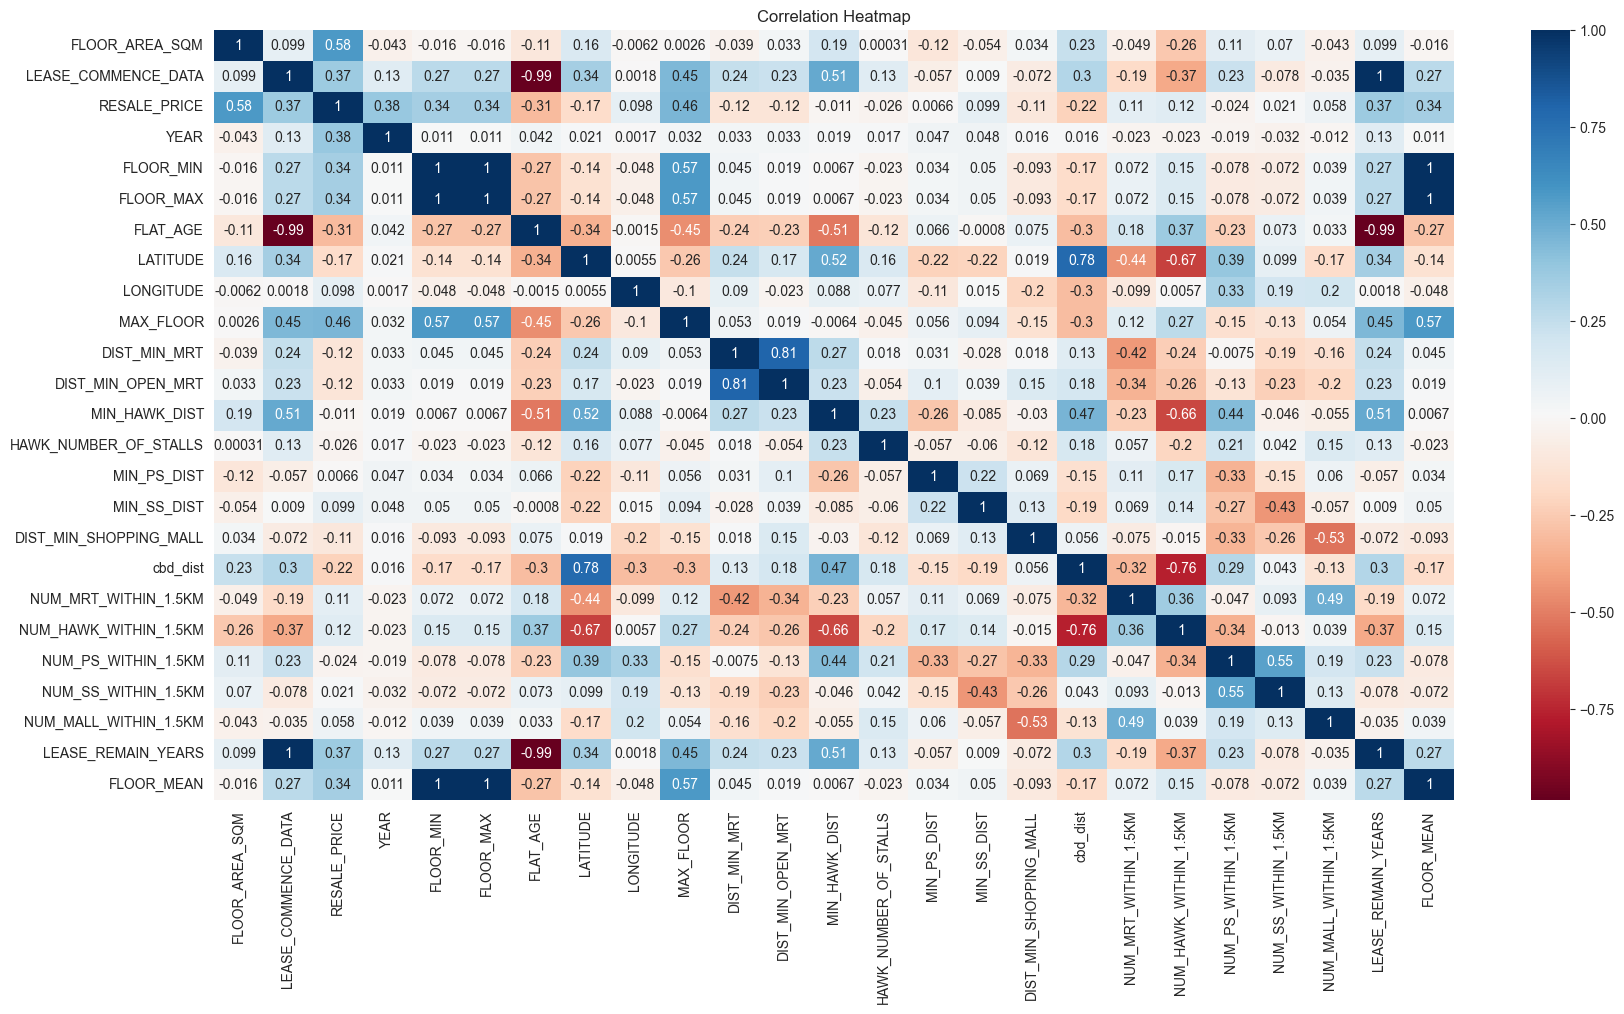

In [179]:
corrMatrix = df_num.corr()

plt.figure(figsize=(20, 10))
plt.title("Correlation Heatmap")
sns.heatmap(
    corrMatrix, 
    xticklabels=corrMatrix.columns,
    yticklabels=corrMatrix.columns,
    cmap='RdBu', 
    annot=True
)

In [180]:
df_num = df_num.drop(columns = ["LEASE_REMAIN_YEARS", "FLOOR_MIN", "FLOOR_MAX", "FLAT_AGE" ])

<Axes: title={'center': 'Correlation Heatmap'}>

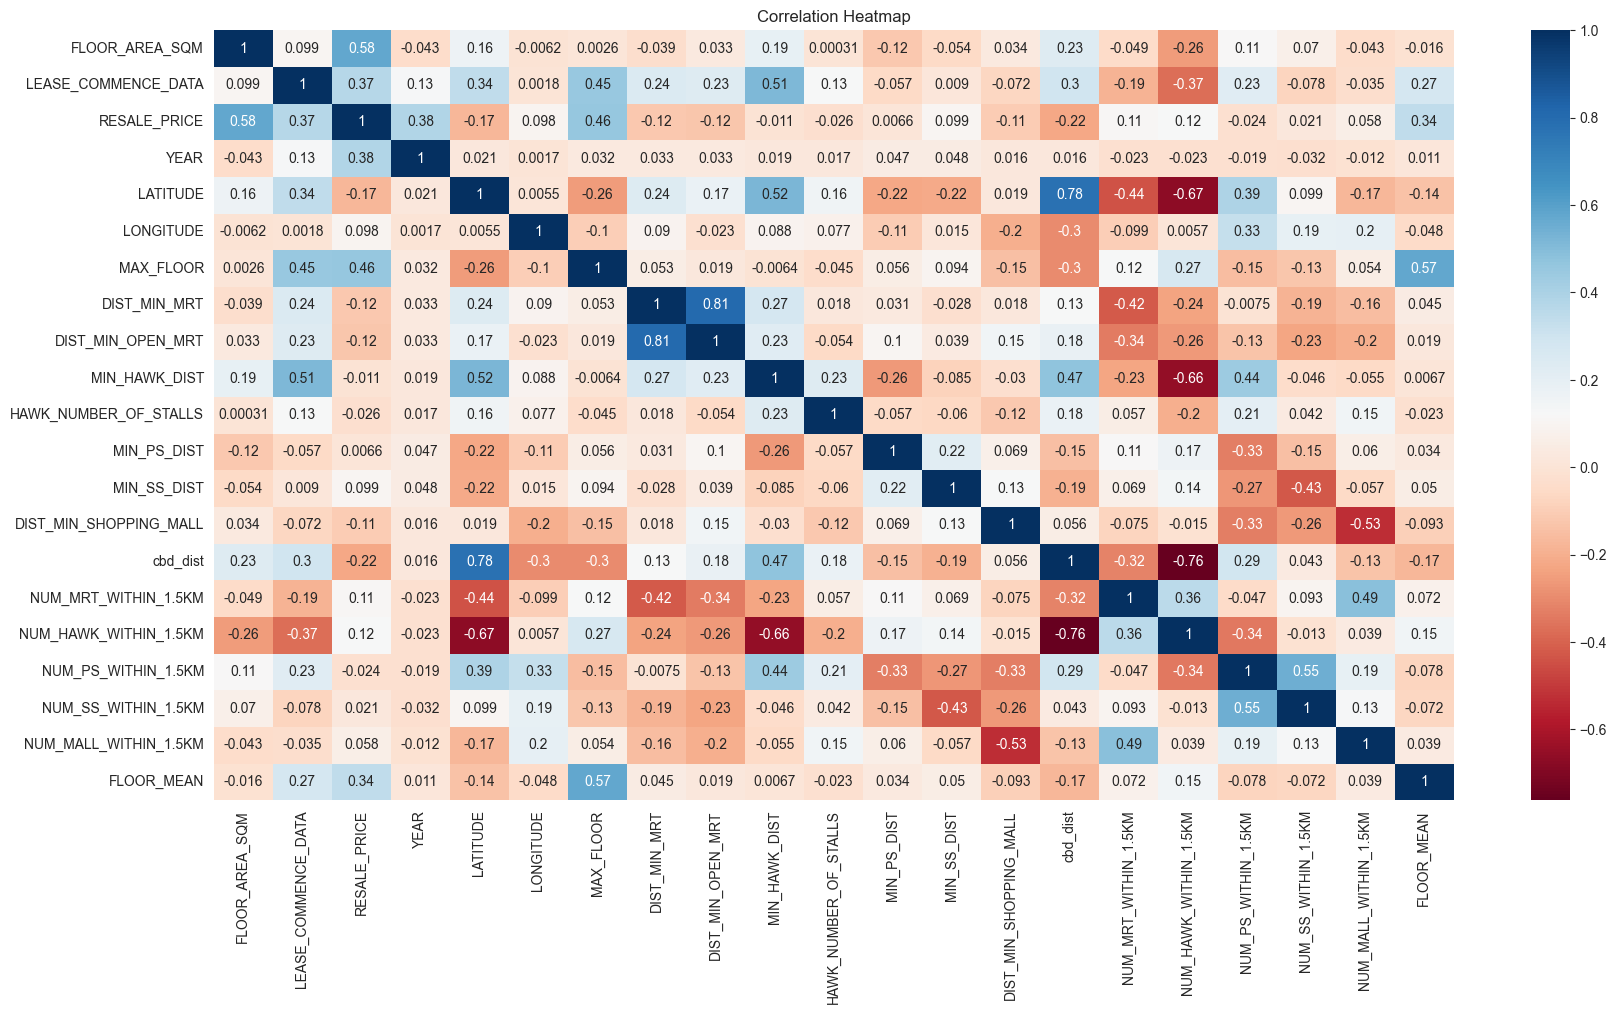

In [181]:
corrMatrix = df_num.corr()

plt.figure(figsize=(20, 10))
plt.title("Correlation Heatmap")
sns.heatmap(
    corrMatrix, 
    xticklabels=corrMatrix.columns,
    yticklabels=corrMatrix.columns,
    cmap='RdBu', 
    annot=True
)

In [182]:
df_num = df_num.drop(columns = ["MIN_HAWK_DIST", "MIN_PS_DIST", "MIN_SS_DIST", "HAWK_NUMBER_OF_STALLS", "NUM_PS_WITHIN_1.5KM",
                                "NUM_SS_WITHIN_1.5KM", "NUM_MALL_WITHIN_1.5KM"])

<Axes: title={'center': 'Correlation Heatmap'}>

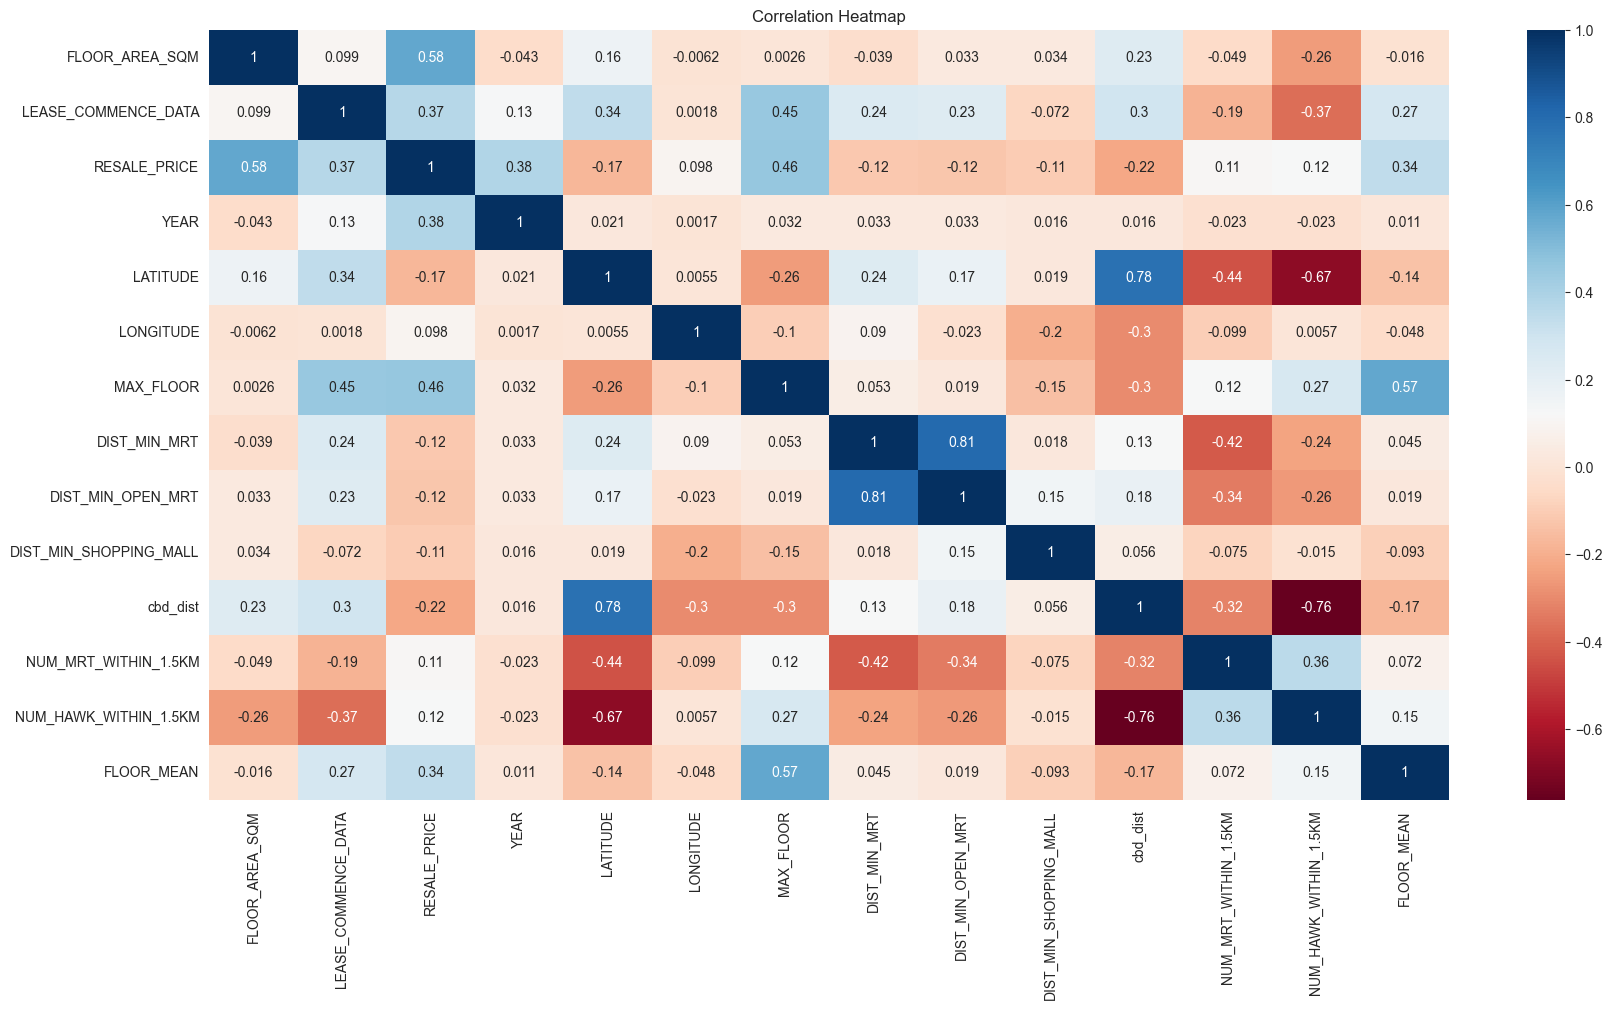

In [183]:
corrMatrix = df_num.corr()

plt.figure(figsize=(20, 10))
plt.title("Correlation Heatmap")
sns.heatmap(
    corrMatrix, 
    xticklabels=corrMatrix.columns,
    yticklabels=corrMatrix.columns,
    cmap='RdBu', 
    annot=True
)

In [184]:
data = data.drop(columns = ["LEASE_REMAIN_YEARS", "FLOOR_MIN", "FLOOR_MAX", "FLAT_AGE" ])
data = data.drop(columns = ["MIN_HAWK_DIST", "MIN_PS_DIST", "MIN_SS_DIST", "HAWK_NUMBER_OF_STALLS", "NUM_PS_WITHIN_1.5KM",
                                "NUM_SS_WITHIN_1.5KM", "NUM_MALL_WITHIN_1.5KM"])

data_test = data_test.drop(columns = ["LEASE_REMAIN_YEARS", "FLOOR_MIN", "FLOOR_MAX", "FLAT_AGE" ])
data_test = data_test.drop(columns = ["MIN_HAWK_DIST", "MIN_PS_DIST", "MIN_SS_DIST", "HAWK_NUMBER_OF_STALLS", "NUM_PS_WITHIN_1.5KM", "NUM_SS_WITHIN_1.5KM", "NUM_MALL_WITHIN_1.5KM"])

<Axes: title={'center': 'Correlation Heatmap'}>

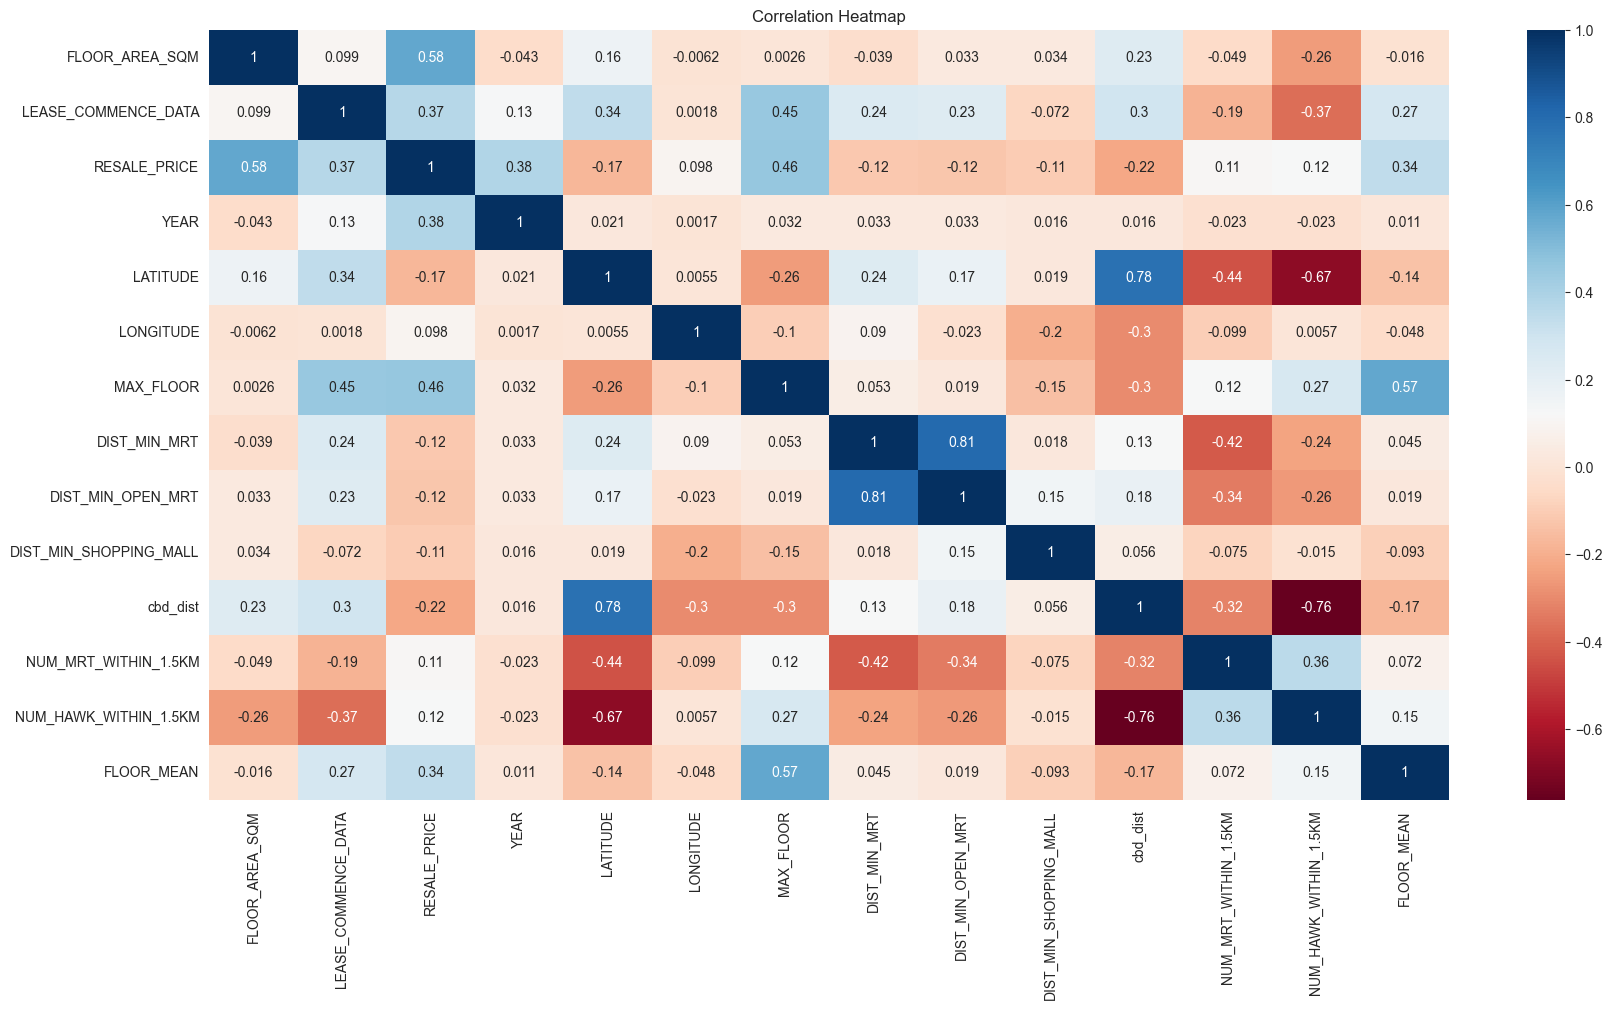

In [185]:
corrMatrix = data.select_dtypes(exclude="object").corr()

plt.figure(figsize=(20, 10))
plt.title("Correlation Heatmap")
sns.heatmap(
    corrMatrix, 
    xticklabels=corrMatrix.columns,
    yticklabels=corrMatrix.columns,
    cmap='RdBu', 
    annot=True
)

In [186]:
data.columns

Index(['TOWN', 'FLAT_TYPE', 'FLOOR_AREA_SQM', 'FLAT_MODEL',
       'LEASE_COMMENCE_DATA', 'RESALE_PRICE', 'YEAR', 'ADDRESS', 'LATITUDE',
       'LONGITUDE', 'MAX_FLOOR', 'PLANNING_AREA', 'DIST_MIN_MRT', 'MRT_STATUS',
       'DIST_MIN_OPEN_MRT', 'HAWK_TYPE', 'HAWK_OWNER',
       'DIST_MIN_SHOPPING_MALL', 'cbd_dist', 'NUM_MRT_WITHIN_1.5KM',
       'NUM_HAWK_WITHIN_1.5KM', 'FLOOR_MEAN'],
      dtype='object')

In [187]:
data_test.columns

Index(['TOWN', 'FLAT_TYPE', 'FLOOR_AREA_SQM', 'FLAT_MODEL',
       'LEASE_COMMENCE_DATA', 'YEAR', 'ADDRESS', 'LATITUDE', 'LONGITUDE',
       'MAX_FLOOR', 'PLANNING_AREA', 'DIST_MIN_MRT', 'MRT_STATUS',
       'DIST_MIN_OPEN_MRT', 'HAWK_TYPE', 'HAWK_OWNER',
       'DIST_MIN_SHOPPING_MALL', 'cbd_dist', 'NUM_MRT_WITHIN_1.5KM',
       'NUM_HAWK_WITHIN_1.5KM', 'FLOOR_MEAN'],
      dtype='object')

In [188]:
data.to_csv("Data/final_train.csv", index = False)
data_test.to_csv("Data/final_test.csv", index = False)

# Model Selection

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [190]:
num_features = ['FLOOR_AREA_SQM', 'LEASE_COMMENCE_DATA', 'YEAR', 'LATITUDE', 'LONGITUDE', 'MAX_FLOOR', 'DIST_MIN_MRT',
                'DIST_MIN_OPEN_MRT', 'DIST_MIN_SHOPPING_MALL', 'FLOOR_MEAN']

cat_features = ['TOWN', 'FLAT_TYPE', 'FLAT_MODEL']

features = cat_features + num_features
target = 'RESALE_PRICE'

In [191]:
X = data[features].copy()
y = data[target].copy()

for col in cat_features:
     X[col] = X[col].astype("category")

In [192]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [194]:
train_pool_full = Pool(X, y, cat_features=cat_features)

params = {
    'subsample': 0.7,
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 5,
    'colsample_bylevel': 1.0,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 100,
    'task_type': 'CPU',
    'devices': '0'
}

cv_data = cv(
    params=params,
    pool=train_pool_full,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    verbose=False,
    plot=False
)

mean_rmse = cv_data['test-RMSE-mean'].iloc[-1]
std_rmse = cv_data['test-RMSE-std'].iloc[-1]

print("\n5-Fold Cross-Validation Results:")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_valid, y_valid, cat_features=cat_features)

final_cat = CatBoostRegressor(**params, verbose=100)

final_cat.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

val_preds = final_cat.predict(val_pool)

mse = mean_squared_error(y_valid, val_preds)
rmse = np.sqrt(mse)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


Training on fold [0/5]

bestTest = 27106.44373
bestIteration = 1998

Training on fold [1/5]

bestTest = 27337.66737
bestIteration = 1999

Training on fold [2/5]

bestTest = 27208.68776
bestIteration = 1999

Training on fold [3/5]

bestTest = 27003.56394
bestIteration = 1999

Training on fold [4/5]

bestTest = 27000.44829
bestIteration = 1999


5-Fold Cross-Validation Results:
Mean RMSE: 27131.4509
Std RMSE: 143.7106

0:	learn: 176258.7628551	test: 175094.7477995	best: 175094.7477995 (0)	total: 143ms	remaining: 4m 44s
100:	learn: 38187.3844680	test: 38509.5588738	best: 38509.5588738 (100)	total: 7.99s	remaining: 2m 30s
200:	learn: 32271.0112675	test: 32891.8817703	best: 32891.8817703 (200)	total: 13.8s	remaining: 2m 3s
300:	learn: 30021.6620422	test: 30885.1938713	best: 30885.1938713 (300)	total: 19.5s	remaining: 1m 49s
400:	learn: 28671.6464094	test: 29748.2173668	best: 29748.2173668 (400)	total: 25.3s	remaining: 1m 40s
500:	learn: 27763.8823747	test: 29033.6264763	best: 29033.6264763 

In [197]:
best_params = {
    'subsample': 1.0,
    'reg_lambda': 3,
    'reg_alpha': 0,
    'min_child_weight': 7,
    'max_depth': 6,
    'learning_rate': 0.05,
    'gamma': 0.2,
    'colsample_bytree': 0.5
}

model = XGBRegressor(
    **best_params,
    n_estimators=2000,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    tree_method='hist',
    verbosity=0,
    enable_categorical=True
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

cv_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf, n_jobs=-1, verbose=1)

mean_rmse = -np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print("\n5-Fold Cross-Validation Results:")
print(f"RMSE scores (per fold): {-cv_scores}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")

final_xgb = XGBRegressor(
    **best_params,
    n_estimators=2000,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    early_stopping_rounds=100,
    tree_method='hist',
    enable_categorical=True,
    verbosity=1
)

final_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=50
)

y_pred = final_xgb.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished



5-Fold Cross-Validation Results:
RMSE scores (per fold): [27220.60744822 27673.1557292  27113.36874561 27352.103498
 27261.63875587]
Mean RMSE: 27324.1748
Std RMSE: 190.6011

[0]	validation_0-rmse:176581.48646	validation_1-rmse:175425.79126
[50]	validation_0-rmse:56005.33748	validation_1-rmse:56215.21115
[100]	validation_0-rmse:38214.28937	validation_1-rmse:38657.96300
[150]	validation_0-rmse:33643.62702	validation_1-rmse:34290.39167
[200]	validation_0-rmse:31554.55455	validation_1-rmse:32362.77394
[250]	validation_0-rmse:30316.96925	validation_1-rmse:31258.86362
[300]	validation_0-rmse:29410.99004	validation_1-rmse:30468.92304
[350]	validation_0-rmse:28801.49694	validation_1-rmse:29949.65213
[400]	validation_0-rmse:28328.28990	validation_1-rmse:29542.83992
[450]	validation_0-rmse:27927.50019	validation_1-rmse:29220.71465
[500]	validation_0-rmse:27611.63314	validation_1-rmse:28974.47829
[550]	validation_0-rmse:27368.69891	validation_1-rmse:28793.83081
[600]	validation_0-rmse:27129.841

In [198]:
from lightgbm import LGBMRegressor

best_params = {
    'subsample': 0.8,
    'reg_lambda': 7,
    'reg_alpha': 0.1,
    'num_leaves': 31,
    'min_child_weight': 7,
    'max_depth': 10,
    'learning_rate': 0.1,
    'colsample_bytree':0.5
}

model = LGBMRegressor(
    **best_params,
    n_estimators=2000,
    objective='regression',
    metric='rmse',
    random_state=42,
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

cv_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf, n_jobs=-1, verbose=1)

mean_rmse = -np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print("\n5-Fold Cross-Validation Results:")
print(f"RMSE scores (per fold): {-cv_scores}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")


final_model = LGBMRegressor(
    **best_params,
    n_estimators=2000,
    objective='regression',
    metric='rmse',
    random_state=42,
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='rmse',
)

y_pred = final_model.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008421 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 1614
[LightGBM] [Info] Total Bins 1615
[LightGBM] [Info] Number of data points in the train set: 129089, number of used features: 13
[LightGBM] [Info] Number of data points in the train set: 129089, number of used features: 13
[LightGBM] [Info] Start training from score 519338.294284
[LightGBM] [Info] Start training from score 519252.513502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in t

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.9s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.4s finished



5-Fold Cross-Validation Results:
RMSE scores (per fold): [27205.39700365 27654.62910273 27175.0096206  27326.55966099
 27377.08814605]
Mean RMSE: 27347.7367
Std RMSE: 170.6389

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 145224, number of used features: 13
[LightGBM] [Info] Start training from score 519550.613608

Final Model Evaluation (Validation Set):
Mean Squared Error: 747970490.4363
Mean Absolute Error: 19887.0183
Root Mean Squared Error: 27349.0492
R² Score: 0.9775
